<a href="https://colab.research.google.com/github/AtulArya7/AtulArya.github.io-SF2/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2 - Sentiment Analysis Using LSTM Model**

*Build a LSTM model to detect sentiment (i.e. detect if a sentence is positive or negative) using 
PyTorch and TorchText. This will be done by using the provided IMDb dataset*

**Name- Atul Arya**

**Roll No.- 18HS20009**

**Steps to follow:**
1. Load in and visualize the data (0.5 point)
2. Data Processing (1 point point)
3. Splitting to train and test data (1 point)
4. Analysing sentiment ( 0.5 point)
5. Tockenization (1 point)
6. Analysis of review length (0.5 point)
7. Padding (0.5 point)
8. Batching and loading as tensor (batch size =50) (1 point)
9. Model Designing (2 point)
10. Training (Calculate training lose and training accuracy) (2 point)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


**1. Load in and visualize the data**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [4]:
import io
data = io.BytesIO(uploaded['IMDB Dataset.csv'])

In [5]:
import io  
data = io.BytesIO(uploaded['IMDB Dataset.csv'])

In [6]:
df = pd.read_csv(data)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


**2. Data Processing**

In [16]:
import re
from collections import Counter
from string import punctuation

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def onehot(X_train):
  # Conversion of word into the binary values.
  universe = []
  
  for sentence in X_train:
    for word in sentence.lower().split():
        word = preprocess_string(word)
        if word not in punctuation:
            universe.append(word)

  corpus = Counter(universe)
  # sorting on the basis of most common words
  corpus_sorted = sorted(corpus,key=corpus.get,reverse=True)[:1000]
  # creating a vocabulary
  vocab = {w:i+1 for i,w in enumerate(corpus_sorted)}
  return vocab

**3. Splitting to train and test data**

We will split data to train and test initially.Doing this on earlier stage allows to avoid data lekage.

In [12]:
from sklearn.model_selection import train_test_split

X,y = df.review.values,df.sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X,y)
# Check the shape of datasets
print("Train_shape:", X_train.shape)
print("Test_shape:", X_test.shape)

Train_shape: (37500,)
Test_shape: (12500,)


In [13]:
X_train

array(["Just watched this on DVD three times - Once the 'normal' way, once with the scenes in consecutive order (in this doozy of a film noir, the beginning, middle and end of the story intertwine), and once with the director's commentary running. Quite amazing. A bare-bones tale, told with more flair, energy and substance than most big-budget overblown features being released today. <br /><br />I think this is an even more accomplished film than the subsequent Memento, which turned me on to Nolan in the first place. Can't wait to see what he does with a bigger budget (and bigger box-office stars) in his next film, Insomnia.",
       'Fairly good movie, but not a true story.<br /><br />Rubin "Hurricane" Carter was a notorius liar, a murder and was never found not guilty. New Jersey State just didn\'t go for it a third time as 20 years had gone. Carter got an offer in 1976: "Pass a lie test and go free". He didn\'t take it. This film should never have been made, but money talks. A lot o

In [15]:
y_train

array(['positive', 'negative', 'negative', ..., 'negative', 'negative',
       'positive'], dtype=object)

**4. Analysing of sentiment**

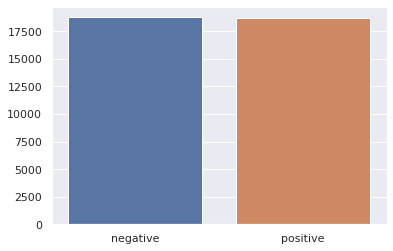

In [23]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
# Representaion of sentiments into bar gaph
count = pd.Series(y_train).value_counts()
x_labels=np.array(['negative','positive'])
sns.barplot(x=x_labels,y=count.values)
plt.show()

In [17]:
vocab=onehot(X_train)
len(vocab)

1000

**5. Tokenization**

In [18]:
def tokenize(X_train,y_train,X_test,y_test):
  final_train, final_test = [],[]
  for sentence in X_train:
          final_train.append([vocab[preprocess_string(word)] 
                              for word in sentence.lower().split() 
                              if preprocess_string(word) in vocab.keys()])
  for sentence in X_test:
          final_test.append([vocab[preprocess_string(word)] 
                              for word in sentence.lower().split() 
                              if preprocess_string(word) in vocab.keys()])
          
  encoded_train = [1 if label =='positive' else 0 for label in y_train]  
  encoded_test = [1 if label =='positive' else 0 for label in y_test] 
  return (np.array(final_train), 
          np.array(encoded_train), 
          np.array(final_test), 
          np.array(encoded_test))

X_train,y_train,X_test,y_test = tokenize(X_train,y_train,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [19]:
X_train

array([list([39, 282, 10, 20, 267, 277, 210, 275, 1, 98, 275, 15, 1, 133, 7, 619, 7, 10, 4, 3, 19, 1, 442, 742, 2, 130, 4, 1, 67, 2, 275, 15, 1, 693, 614, 179, 477, 3, 802, 541, 15, 51, 2, 70, 86, 873, 106, 609, 644, 12, 12, 9, 102, 10, 6, 33, 54, 51, 19, 70, 1, 62, 670, 69, 20, 5, 7, 1, 87, 274, 172, 857, 5, 64, 48, 27, 121, 15, 3, 396, 2, 401, 7, 24, 355, 19]),
       list([951, 49, 17, 18, 21, 3, 286, 12, 13, 3, 3, 595, 2, 13, 108, 249, 21, 161, 39, 150, 138, 16, 8, 3, 859, 59, 14, 151, 66, 754, 182, 33, 7, 3, 2, 138, 936, 27, 150, 185, 8, 10, 19, 139, 108, 25, 75, 92, 18, 289, 3, 165, 4, 84, 25, 63, 470, 7, 2, 51, 70, 472, 132, 3, 12]),
       list([5, 1, 475, 4, 10, 67, 29, 284, 7, 3, 298, 16, 866, 1, 272, 67, 6, 437, 20, 547, 35, 3, 204, 16, 595, 76, 1, 550, 42, 972, 30, 1, 4, 42, 120, 40, 42, 16, 1, 2, 23, 2, 483, 21, 1, 427, 5, 128, 1, 218, 16, 464, 39, 5, 372, 178, 731, 10, 44, 3, 355, 5, 1, 2, 600, 3, 252, 15, 3, 41, 12, 47, 23, 39, 191, 913, 2, 16, 10, 5, 26, 14, 3, 19, 646,

In [20]:
X_test

array([list([7, 4, 167, 32, 1, 706, 149, 2, 33, 228, 32, 10, 19, 35, 3, 1, 555, 4, 4, 1, 28, 4, 1, 101, 766, 109, 14, 3, 114, 2, 469, 10, 89, 56, 923, 47, 6, 159, 41, 89, 40, 24, 238, 5, 94, 8, 11, 24, 2, 57, 37, 73, 59, 2, 867, 768, 20, 89, 27, 6, 2, 627, 1, 171, 463, 16, 33, 294, 36, 68, 94, 22, 112, 89, 54, 50, 27, 6, 106, 3, 3, 16, 12, 31, 4, 1, 20, 1, 807, 544, 13, 5, 10, 2, 238, 31, 9, 438, 5, 81, 13, 89, 2, 360, 89, 5, 74, 126, 307]),
       list([1, 933, 6, 3, 17, 7, 15, 608, 8, 6, 3, 354, 2, 27, 121, 94, 3, 298, 255, 8, 6, 21, 16, 142, 11, 408, 2, 1, 77, 356, 27, 44, 411, 585, 16, 10, 19, 6, 3, 165, 51, 298, 70, 12, 8, 13, 463, 1, 933, 18, 14, 3, 52, 658, 463, 1, 2, 517, 1, 107, 953, 584, 1, 413, 13, 5, 7, 20, 63, 12, 1, 19, 76, 5, 277, 4, 305, 142, 36, 112, 93, 142, 36, 112, 93, 2, 142, 36, 1, 93, 356, 12, 1, 820, 16, 1, 19, 6, 11, 23, 41, 2, 3, 928, 5, 95, 188, 157, 71, 31, 411, 16, 1, 10, 167, 6, 45, 32, 46, 36, 3, 114, 576, 5, 195, 95, 1, 34, 344, 72, 8, 213, 26, 167, 178,

In [21]:
y_train

array([1, 0, 0, ..., 0, 0, 1])

In [22]:
y_test

array([0, 1, 0, ..., 1, 0, 0])

**6. Analysis of review length**

In [24]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).describe()

count    37500.000000
mean       174.491813
std        124.531409
min          7.000000
25%         98.000000
50%        134.000000
75%        211.000000
max       1472.000000
dtype: float64

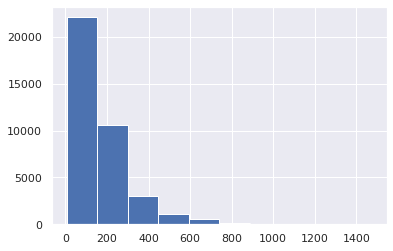

In [25]:
pd.Series(rev_len).hist()
plt.show()

**7. Padding**

In [26]:

pad_max=np.quantile(rev_len, 0.999)
pad_max

789.0019999999931

99.9% of the reviews are within the word length of 789

In [27]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for i, review in enumerate(sentences):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_len]
    return features

In [29]:
# maximum padding length is 800 
# since only 0.1% of the reviews are above this length
X_train_pad = padding(X_train, 800)
X_test_pad = padding(X_test, 800)

**8. Batching and loading as tensor (batch size =50)**

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [50]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_X, sample_y = dataiter.next()

print('Tensor size: ', sample_X.size()) # batch_size, seq_length
print('Reviews: \n', sample_X)
print('Sentiments: \n', sample_y)

Tensor size:  torch.Size([50, 800])
Reviews: 
 tensor([[  0,   0,   0,  ...,   7,   5,   2],
        [  0,   0,   0,  ...,  15,   2,  14],
        [  0,   0,   0,  ..., 165,  51, 248],
        ...,
        [  0,   0,   0,  ...,   5,   1,  12],
        [  0,   0,   0,  ...,  27,  92,   8],
        [  0,   0,   0,  ...,   1,   2, 488]])
Sentiments: 
 tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0])


*We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights*

**9. Model Designing**

In [32]:
from torch import nn

class SentimentLSTM(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension
        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward (self, input_words, h):
        batch_size = input_words.size(0)                          # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h
    
    
    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

In [33]:
n_vocab = len(vocab)+1
n_embed = 100
n_hidden = 32
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 2

net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(1001, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**10. Training (Calculate training lose and training accuracy)**

In [34]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.05)


print_every = 50
step = 0
n_epochs = 5
clip = 5  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loss=[]
train_acc=[]

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

for epoch in range(n_epochs):
    h = net.init_hidden(batch_size)
    for inputs, labels in train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, h)


        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        accuracy = acc(output,labels)

        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()

        
        if (step % print_every) == 0:
          lossval=loss.item()
          accval=accuracy         

          print("Epoch: {}/{}".format((epoch+1), n_epochs),
                "Step: {}".format(step),
                "Loss: {:.4f}".format(lossval),
                "Accuracy: {:.4f}".format(accval/batch_size)
                )

          train_loss.append(lossval)
          train_acc.append(accval)

          net.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 1/5 Step: 50 Loss: 0.7277 Accuracy: 0.5000
Epoch: 1/5 Step: 100 Loss: 0.6798 Accuracy: 0.6000
Epoch: 1/5 Step: 150 Loss: 0.7086 Accuracy: 0.5400
Epoch: 1/5 Step: 200 Loss: 0.7826 Accuracy: 0.4600
Epoch: 1/5 Step: 250 Loss: 0.7206 Accuracy: 0.5000
Epoch: 1/5 Step: 300 Loss: 0.7071 Accuracy: 0.5800
Epoch: 1/5 Step: 350 Loss: 0.7016 Accuracy: 0.5200
Epoch: 1/5 Step: 400 Loss: 0.6890 Accuracy: 0.4800
Epoch: 1/5 Step: 450 Loss: 0.6512 Accuracy: 0.5800
Epoch: 1/5 Step: 500 Loss: 0.6289 Accuracy: 0.7400
Epoch: 1/5 Step: 550 Loss: 0.6420 Accuracy: 0.6400
Epoch: 1/5 Step: 600 Loss: 0.6898 Accuracy: 0.5800
Epoch: 1/5 Step: 650 Loss: 0.7244 Accuracy: 0.5200
Epoch: 1/5 Step: 700 Loss: 0.6406 Accuracy: 0.5400
Epoch: 1/5 Step: 750 Loss: 0.6814 Accuracy: 0.5800
Epoch: 2/5 Step: 800 Loss: 0.6437 Accuracy: 0.6000
Epoch: 2/5 Step: 850 Loss: 0.7201 Accuracy: 0.4200
Epoch: 2/5 Step: 900 Loss: 0.7302 Accuracy: 0.4800
Epoch: 2/5 Step: 950 Loss: 0.7151 Accuracy: 0.4600
Epoch: 2/5 Step: 1000 Loss: 0.67

In [35]:
torch.save(net.state_dict(), "net_params.pt")

In [36]:
epoch_loss=[]
temp=[]
for i in range(0,len(train_loss)):
  temp.append(train_loss[i])
  i +=1
  if (i % (len(train_loss)/n_epochs)==0):
    epoch_loss.append(np.mean(temp))
    temp=[]

epoch_acc=[]
temp=[]
for i in range(0,len(train_acc)):
  temp.append(train_acc[i]/batch_size)
  i +=1
  if (i % (len(train_acc)/n_epochs)==0):
    epoch_acc.append(np.mean(temp))
    temp=[]

In [37]:
epoch_loss, epoch_acc

([0.6916708389918009,
  0.7072675585746765,
  0.691397484143575,
  0.6807681759198506,
  0.6944839119911194],
 [0.5573333333333333, 0.49866666666666665, 0.516, 0.5666666666666668, 0.528])

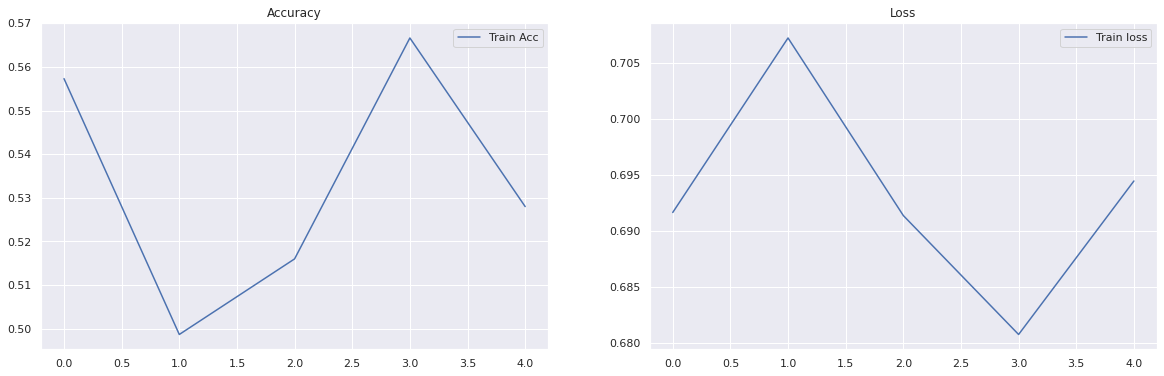

In [52]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
#plt.plot(train_acc, label='Train Acc')
plt.plot(epoch_acc, label='Train Acc')
plt.title("Accuracy")
plt.legend()
    
plt.subplot(1, 2, 2)
#plt.plot(train_loss, label='Train loss')
plt.plot(epoch_loss, label='Train loss')
plt.title("Loss")
plt.legend()

plt.show()

**Test Accuracy and Test Loss**

In [39]:
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size)

for test_inputs, test_labels in test_loader:
    
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_h = tuple([each.data for each in test_h])

    test_output, test_h = net(test_inputs, test_h)
    test_loss = criterion(test_output.squeeze(), test_labels.float())
    test_losses.append(test_loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))


Test Loss: 0.6861
Test Accuracy: 0.49


**Prediction & Inference**

In [40]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = net.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = net(inputs, h)
        return(output.item())

In [45]:
def results(df, index):
  sentiment=df.sentiment[index]
  review=df.review[index]
  prob=predict_text(review)
  prediction = "positive" if prob > 0.5 else "negative"
  print("Review:\n",review)
  print("Actual Sentiment:", sentiment)
  print("Predicted Sentiment:", prediction)

In [46]:
random=np.random.randint(0, 50001)
results(df, random)

Review:
 This documentary attempts comedy, but never quite gets there for me. Camp? Ehn, maybe. The more apt word that everyone will agree on -- and have a hard time avoiding in any review -- is kitsch. It dripped kitsch. It was as if the film makers had worried their viewers would take the movie too seriously, and so they bent over backwards to insert kitsch and proclaim, "We're joking around here! See???"<br /><br />In short, I felt it was trying too hard. For example, the sock puppets that introduced each scene were (to me) annoying when I'm sure they were meant to be amusing -- or at least (ahem) kitsch-ey.<br /><br />Do not, however, avoid this movie based on my complaints. Just be ready to revel in kitsch rather than having it thrust at you unprepared. If you're interested in lighthearted fare, you could do far, far worse. At the very least, the facts surrounding the rise and fall of the Bakers make this interesting and worth a view. At best, gaggles of like minded kitsch lovers 

In [47]:
random=np.random.randint(0, 50001)
results(df, random)

Review:
 B.B. Thornton proves to be a great actor in this little seen movie. Thornton really gets into his characters--literally. I caught this on cable one night and enjoyed it. Too bad it was released nationwide in theaters the same year as "Fear and Loathing" and "Half-Baked."
Actual Sentiment: positive
Predicted Sentiment: positive


In [48]:
random=np.random.randint(0, 50001)
results(df, random)

Review:
 One thing I have noticed about British horror movies from the 1970s is that they don`t hold up to repeated viewing THEATRE OF BLOOD is a case in point as are all those Amicus anthology movies . Add THE BEAST IN THE CELLAR to the list <br /><br />Much of the drama of this movie revolves around the build up of a plot revelation at the end . Once you know what the revelation is this becomes a rather flat film . It does open with a fairly good hook but after that we`re treated to long boring sequences of two old ladies making small talk . Correct me if I`m wrong but how many people watch a horror movie expecting a couple of old ladies making small talk ? The only sort of interest to be found in THE BEAST IN THE CELLAR is the anti-smoking stance . Some people have mentioned that this is an anti-war or anti-military film but watch carefully and you`ll see that everytime a squaddie lights up for a fly puff he gets killed . Rather strange considering attitudes to smoking weren`t nearl

In [49]:
random=np.random.randint(0, 50001)
results(df, random)

Review:
 This movie has recieved horrible ratings from just about everyone who has voted here but i am here to say if you like movies like Dude Wheres my Car and Dumb and Dumber this movie is for you. If your into movies like Citizen Kane and Casablanca id have to sugest you in a different angle. Yet i still love this movie and everything about it even if it is kind of "kiddy" this is one of the few movies me and my freinds have been able to keep watching over the years and quote whenever possible. GREAT MOVIE. This movie should the AFIs number 1 because its so friggin' high class. The only problem with this movie is you may have trouble seeing it because it was a made for tv movie on a channel that no longer exists. So i dont know how to get this movie, id like to buy it for dvd but i cant find it anywhere. I still have it taped from when it was first on, you can come over if you want and watch it bute i might be sleeping. this movie rocks and thats basicly all you need to know.
Actua